# Imports

In [43]:
import os
import tempfile
import numpy as np
import pandas as pd

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

# Network

In [44]:
# Load premade network
net = pn.four_loads_with_branches_out()

  4%|▍         | 1/24 [11:17<4:19:49, 677.82s/it]


In [45]:
# Load premade network
net = pn.four_loads_with_branches_out()

from numpy.random import choice
from numpy.random import normal

def choose_bus():
    # selects random bus node
    list = [6,7,8,9]
    return choice(list)

def load_val():
    # randomized bus load value generation
    # loc: mean, scale: std
    return normal(loc=0.085, scale=0.01)

def load_bus_single(net):
    # apply a single load to bus
    
    # net.load.p_mw.at[choose_bus()] = load_val()
    pp.create_sgen(net, 7, p_mw=-1*load_val(), name='sgen1', q_mvar=0)
    return net

In [ ]:
net = load_bus_single(net)
pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-0.228328,-0.051387
1,0.981745,-1.887630,0.000000,0.000000
2,0.964529,-2.045016,0.000000,0.000000
3,0.949774,-2.204763,0.000000,0.000000
4,0.944759,-2.210759,0.000000,0.000000
5,0.942248,-2.213780,0.000000,0.000000
6,0.962077,-2.047912,0.030000,0.010000
7,0.940040,-2.362642,0.126532,0.010000
8,0.942255,-2.213777,0.030000,0.010000
9,0.939738,-2.216814,0.030000,0.010000


In [52]:
net.load.name.at[0] = "load1_p"
net.load.name.at[1] = "load2_p"
net.load.name.at[2] = "load3_p"
net.load.name.at[3] = "load4_p"
net.load.name

net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,load1_p,6,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
1,load2_p,7,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
2,load3_p,8,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
3,load4_p,9,0.03,0.01,0.0,0.0,NaN,1.0,True,wye


<AxesSubplot:>

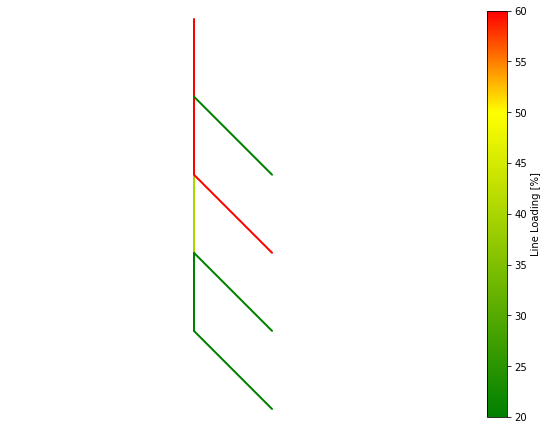

In [ ]:
cmap_list=[(20, "green"), (50, "yellow"), (60, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2, use_bus_geodata=True)
plot.draw_collections([lc], figsize=(8,6))

# Time Series

In [66]:
def timeseries_example(output_dir, net):
    # 1. create test net
#     net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # 3. create controllers (to control P values of the load and the sgen)
    net=create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

In [67]:
def create_data_source(n_timesteps):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 1.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 1.
    profiles['load2_p'] = np.random.random(n_timesteps) * 1.
    profiles['sgen2_p'] = np.random.random(n_timesteps) * 1.
    profiles['load3_p'] = np.random.random(n_timesteps) * 1.
    profiles['sgen3_p'] = np.random.random(n_timesteps) * 1.
    profiles['load4_p'] = np.random.random(n_timesteps) * 1.
    profiles['sgen4_p'] = np.random.random(n_timesteps) * 1.

    ds = DFData(profiles)

    return profiles, ds

In [68]:
profiles, ds = create_data_source(n_timesteps=24)
ds

DFData with 24 rows and 8 columns: ['load1_p' 'sgen1_p' 'load2_p' 'sgen2_p' 'load3_p' 'sgen3_p' 'load4_p'
 'sgen4_p']

In [69]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b3, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

tnet = simple_test_net()
tnet.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,sgen1,4,20.0,0.15,NaN,1.0,True,wye,True


In [70]:
tnet.load.name.at[0]

'load1'

In [71]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load2_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen2_p"])
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load3_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen3_p"])
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load4_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen4_p"])

In [72]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow


In [73]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

timeseries_example(output_dir, net)

Results can be found in your local temp folder: C:\Users\panto\AppData\Local\Temp\time_series_example


TypeError: argument of type 'NoneType' is not iterable

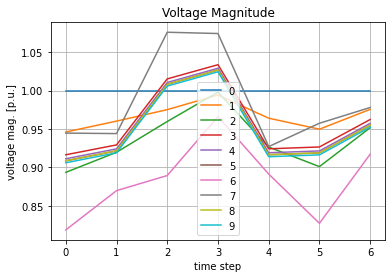

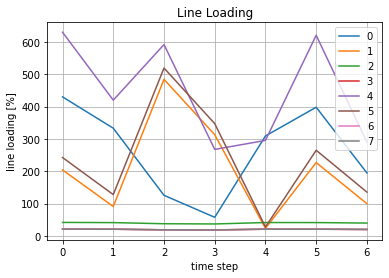

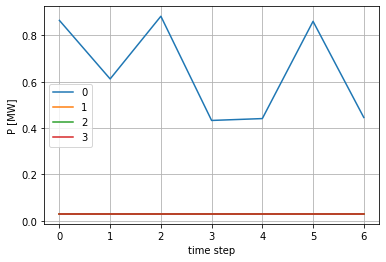

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()